D:\Storage\Repositories\wiosym\data_raw\glo\pres\cc_sealev\cmems\byq2303301924

# Overview
## Dataset
This dataset provides statistical indicators of tides, storm surges and sea level that can be used to characterize global sea level in present-day conditions and also to assess changes under climate change. The indicators calculated include extreme-value indicators (e.g. return periods including confidence bounds for total water levels and surge levels), probability indicators (e.g. percentile for total water levels and surge levels). They provide a basis for studies aiming to evaluate sea level variability, coastal flooding, coastal erosion, and accessibility of ports at a global scale. The extreme value statistics for different return periods can be used to assess the frequency of an event and form the basis of risk assessments. The global coverage allows for world-wide assessments that are particularly useful for the data scarce regions where detailed modelling studies are currently lacking.

The indicators are computed from time series data available in a related dataset in the Climate Data Store named Global sea level change time series from 1950 to 2050 derived from reanalysis and high resolution CMIP6 climate projections (see Related data), where further details of the modelling are provided. The indicators are produced for three different 30-year periods corresponding to historical, present, and future climate conditions (1951-1980, 1985-2014, and 2021-2050). The future period is based on global climate projections using the high-emission scenario SSP5-8.5. The dataset is based on climate forcing from ERA5 global reanalysis and 4 Global Climate Models (GCMs) of the high resolution Coupled Model Intercomparison Project Phase 6 (CMIP6) global climate projection dataset from the High Resolution Model Intercomparison Project (HighResMIP) multi-model ensemble. An estimate of the uncertainties associated with the climate forcing has been obtained through the use of a multi-model ensemble. Each of the indicators provides ensemble statistics computed across the 4 members of the HighResMIP ensemble (e.g. median, mean, standard deviation, range). Absolute and relative changes for the future period (2015-2050) relative to the present-day (1985-2014) are provided to assess climate change impacts on water levels.

This dataset was produced on behalf of the Copernicus Climate Change Service.

Sanne Muis, Maialen Irazoqui Apecechea, José Antonio Álvarez, Martin Verlaan, Kun Yan, Job Dullaart, Jeroen Aerts, Trang Duong, Rosh Ranasinghe, Dewi le Bars, Rein Haarsma, Malcolm Roberts, (2022): Global sea level change indicators from 1950 to 2050 derived from reanalysis and high resolution CMIP6 climate projections. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). 

DOI: 10.24381/cds.6edf04e0 (Accessed on 30/3/2023)


Data product used:

50-year return period (for surge) best-fit absolute value of teh surge level from reanalysis.


# Import necessary packages

In [1]:
# File system
import os, gc

# Computation and plotting
import numpy as np
from scipy.interpolate import griddata, interp1d

import matplotlib.pyplot as plt
import cmocean.cm as cmo

# Query from CMEMS
import motuclient

# NetCDF and geotiff functionality
import xarray as xr
import rioxarray as rxr
from pyproj import Proj, Transformer, CRS

# Data settings and boundaries

In [2]:
# WIOSYM area bounded by:
# Lat 42° S, 18° N
# Long 6° E, 80° E
lat_north = 18.56
lat_south = -42.5
lon_west = 5.5
lon_east = 80.5



In [3]:
out = xr.open_dataset('reanalysis_surge_actual-value_1985-2014_rp50_best-fit_v1.nc')
out

<xarray.Dataset>
Dimensions:                  (stations: 43119)
Coordinates:
  * stations                 (stations) uint16 0 1 2 3 ... 43731 43732 43733
    station_x_coordinate     (stations) float64 ...
    station_y_coordinate     (stations) float64 ...
Data variables:
    return_mean_surge_level  (stations) float64 ...
Attributes: (12/34)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_extreme_value_analysis
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         return values for surge levels
    ...                            ...
    geospatial_vertical_max:       9.762
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up
    time_coverage_start:           1985
    time_coverage_end:             2014
    experiment:

# Load WIOSYM grid coordinates

In [4]:
# Open masked grid file
grid1km = rxr.open_rasterio('../grid_1km_v01.1.tif',
                                 masked=True)
# Create coordinate grid
grid_lon, grid_lat = np.meshgrid(grid1km.x.values,grid1km.y.values)
crs = CRS.from_proj4(grid1km.rio.crs.to_proj4())
proj = Transformer.from_crs(crs, crs.geodetic_crs)

# Remap to prohection
grid_lon, grid_lat = proj.transform(grid_lon,grid_lat)

### Load downloaded data and assemble climatologies / perform averaging

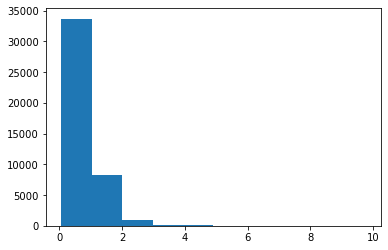

In [5]:
_  = plt.hist( out.return_mean_surge_level.values)

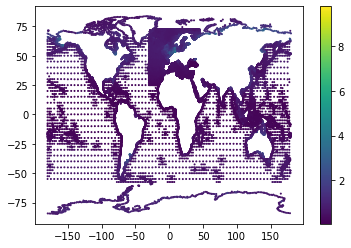

In [6]:
plt.scatter(out.station_x_coordinate.values, out.station_y_coordinate.values, 1, out.return_mean_surge_level.values)
plt.colorbar()

## Start gridding

In [7]:
raster = griddata((out.station_x_coordinate.values, out.station_y_coordinate.values), out.return_mean_surge_level.values, (grid_lon, grid_lat))

### Save

In [8]:
grid1km = grid1km.mean('band')

In [9]:
grid1km.values = (grid1km.values*0 + raster)*1000
grid1km.attrs['scale_factor'] = 1000
grid1km.rio.to_raster("grid_1km_stormSurges_byq.tif",dtype='float64')

### Visualise

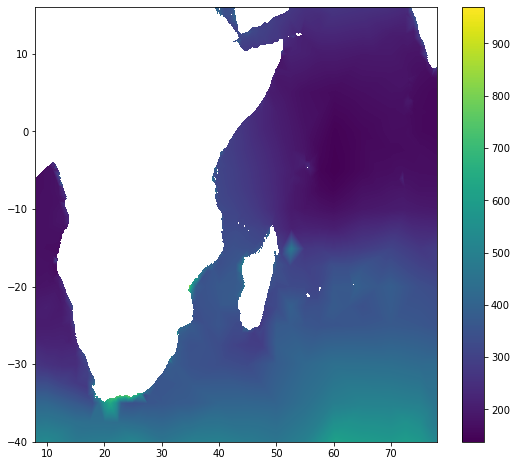

In [10]:
plt.figure(figsize=(9,8))
plt.pcolormesh(grid_lon, grid_lat, grid1km.values, shading='auto')
plt.colorbar()